<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

# This setting widens how many characters pandas will display 
# in a column:
pd.options.display.max_colwidth = 400

---

## Load data

In [3]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...
# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


In [4]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9916 entries, 0 to 9915
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   #AUTHID  9916 non-null   object 
 1   STATUS   9916 non-null   object 
 2   sEXT     9916 non-null   float64
 3   sNEU     9916 non-null   float64
 4   sAGR     9916 non-null   float64
 5   sCON     9916 non-null   float64
 6   sOPN     9916 non-null   float64
 7   cEXT     9916 non-null   object 
 8   cNEU     9916 non-null   object 
 9   cAGR     9916 non-null   object 
 10  cCON     9916 non-null   object 
 11  cOPN     9916 non-null   object 
 12  DATE     9916 non-null   object 
dtypes: float64(5), object(8)
memory usage: 1007.2+ KB


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [5]:
# create new column count status length
df['status_length'] = df['STATUS'].apply(len)

In [6]:
# check status length work correctly
df[['STATUS', 'status_length']].head()

,STATUS,status_length
0,likes the sound of thunder.,27
1,is so sleepy it's not even funny that's she can't get to sleep.,63
2,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",121
3,likes how the day sounds in this new song.,42
4,is home. <3,11


**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [7]:
# create column that store words count
df['status_word_count'] = df['STATUS'].str.split().str.len()

In [8]:
# check that working correctly
df[['STATUS', 'status_word_count']].head()

,STATUS,status_word_count
0,likes the sound of thunder.,5
1,is so sleepy it's not even funny that's she can't get to sleep.,13
2,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",26
3,likes how the day sounds in this new song.,9
4,is home. <3,3


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [9]:
# five longest status word count
df[['STATUS', 'status_word_count']].sort_values('status_word_count', ascending=False).head()

,STATUS,status_word_count
496,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",89
6989,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x",85
5208,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age 32. On the positive side, I have lost 5 of the 8 l...",84
7976,"""I said he's a fairy I do suppose//flyin thru the air in pantyhose//he may be very sexy or even cute//but he looks like a sucka in a blue and red suit//I said you need a man who's got finesse//& his whole name across his chest//he may be able to fly all thru the night//but can he rock a party til the early light//he can't satisfy you with his little worm//but I can bust you out w my Super sper...",83
5680,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",83


In [10]:
# five shortest status word count
df[['STATUS', 'status_word_count']].sort_values('status_word_count', ascending=True).head()

,STATUS,status_word_count
8178,157,1
4170,"wed,.",1
2016,HOUSE!,1
956,Err:509,1
4177,confused,1


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

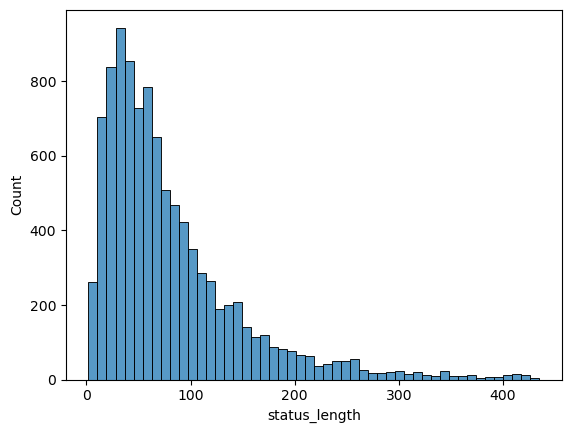

In [11]:
# plot status length distribution
sns.histplot(x='status_length', data=df, bins=50);

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

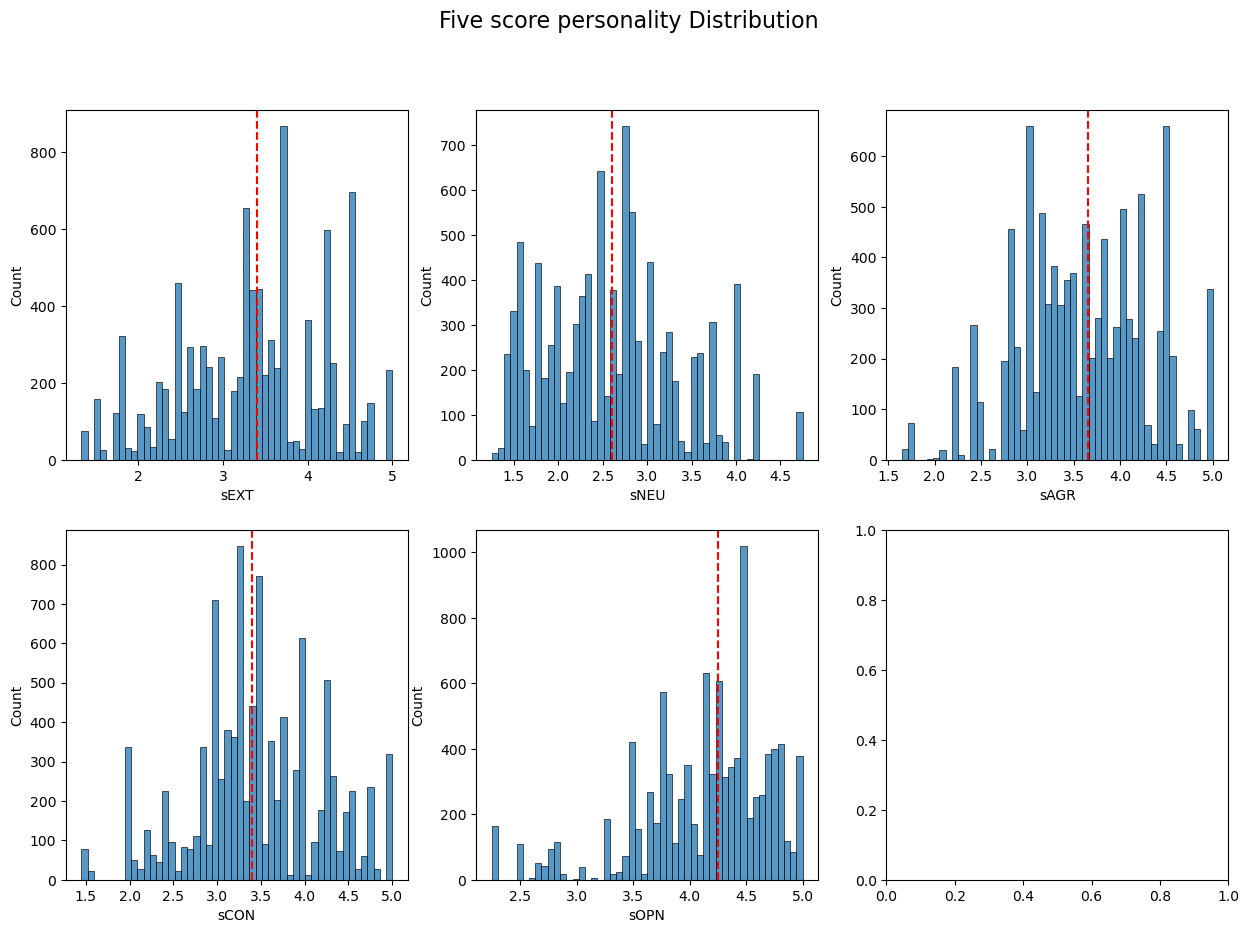

In [12]:
# plot five score distributions
fig, axes = plt.subplots(2, 3, figsize=(15,10))

plt.suptitle('Five score personality Distribution', size=16)
for i, col in enumerate(['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']):
    x = i // 3
    y = i % 3
    sns.histplot(ax = axes[x, y], x = col, data = df, bins = 50)
    axes[x, y].axvline(x=df[col].median(), color='r', linestyle='--')

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [13]:
# count users unique
df['#AUTHID'].nunique()

250

In [14]:
# count unique user posts
df.groupby('#AUTHID')[['status_word_count']].count().sort_values('status_word_count', ascending=False)

,status_word_count
#AUTHID,
e6cdef6f475cce3023c5b715f8c9f110,223
6f2bebc01062eb8334dccba3e048fdb5,219
527ed53d2ba3a3bc417b8402d5b2f556,194
d7e500ad854a1b6ced39e53a525b8a6d,184
0737e4e4980f56c9fb1cb5743001c917,172
...,...
ac8bf16a381d07c01b11651994ecb746,1
5532642937eb3497a43e15dbb23a9d2d,1
22d1f7b24168528163c515b1c96a879c,1


## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [15]:
# Create new dataframe that store unique users
unique_users = df.drop_duplicates(subset=['#AUTHID'])
unique_users = unique_users.drop(columns=['STATUS', 'DATE', 'status_length', 'status_word_count'])

In [16]:
# check rows and columns
unique_users.shape

(250, 11)

**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

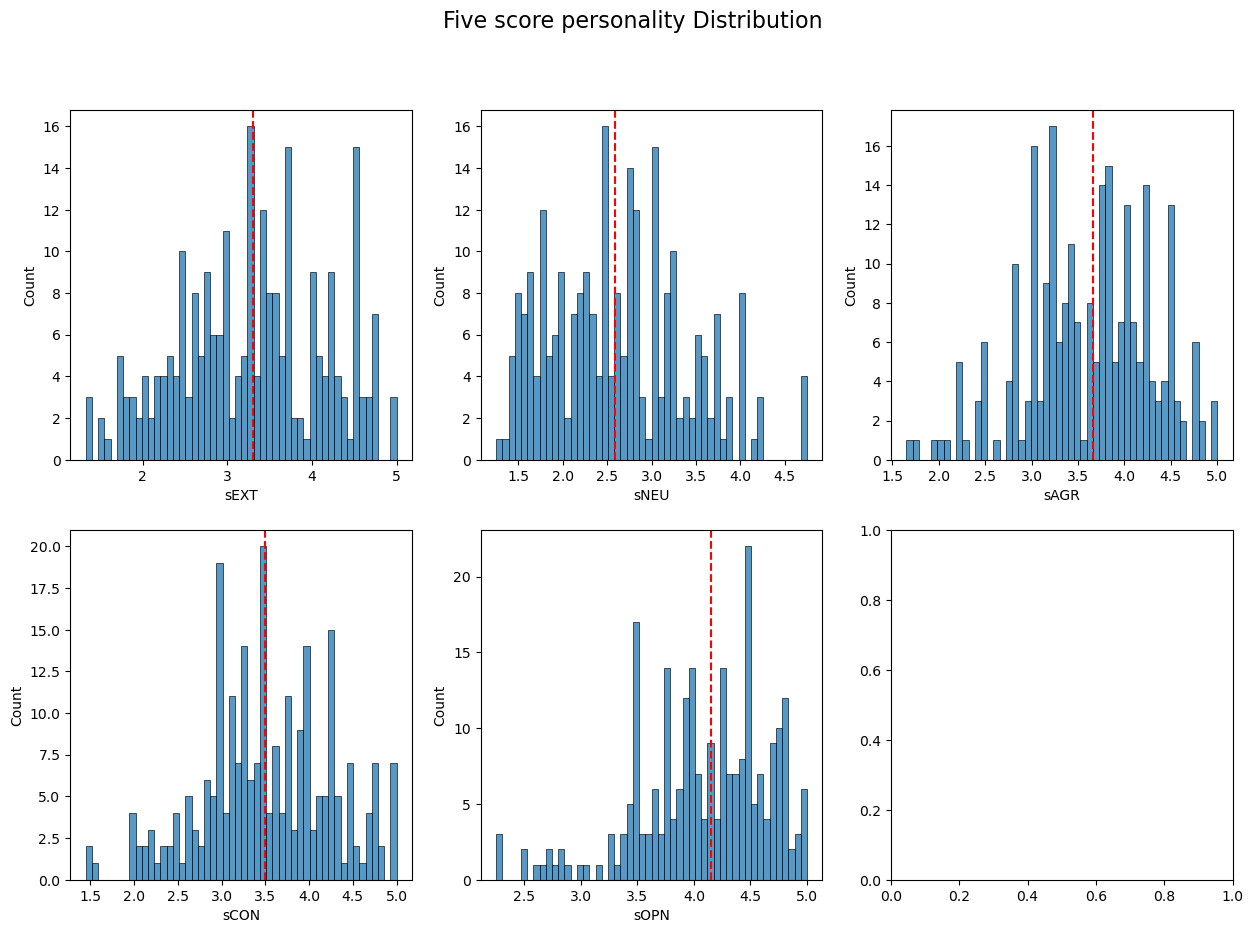

In [17]:
# plot five score distributions
fig, axes = plt.subplots(2, 3, figsize=(15,10))

plt.suptitle('Five score personality Distribution', size=16)
for i, col in enumerate(['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']):
    x = i // 3
    y = i % 3
    sns.histplot(ax = axes[x, y], x = col, data = unique_users, bins = 50)
    axes[x, y].axvline(x=unique_users[col].median(), color='r', linestyle='--')

**Use the `.describe()` method on `unique_users`:**

In [18]:
# summary statistics on unique_user df
unique_users.describe().round(2)

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.00,250.00,250.00,250.00,250.00
mean,3.29,2.63,3.60,3.52,4.08
std,0.86,0.78,0.67,0.74,0.58
min,1.33,1.25,1.65,1.45,2.25
25%,2.66,2.00,3.15,3.00,3.75
50%,3.30,2.59,3.66,3.50,4.15
75%,4.00,3.15,4.10,4.05,4.50
max,5.00,4.75,5.00,5.00,5.00


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

**plot distribution**
   - when want to see trend of data.

**table of summary statisics**
   - after ploted if the distribution is interesting then find the actual values for check the assumptions.

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

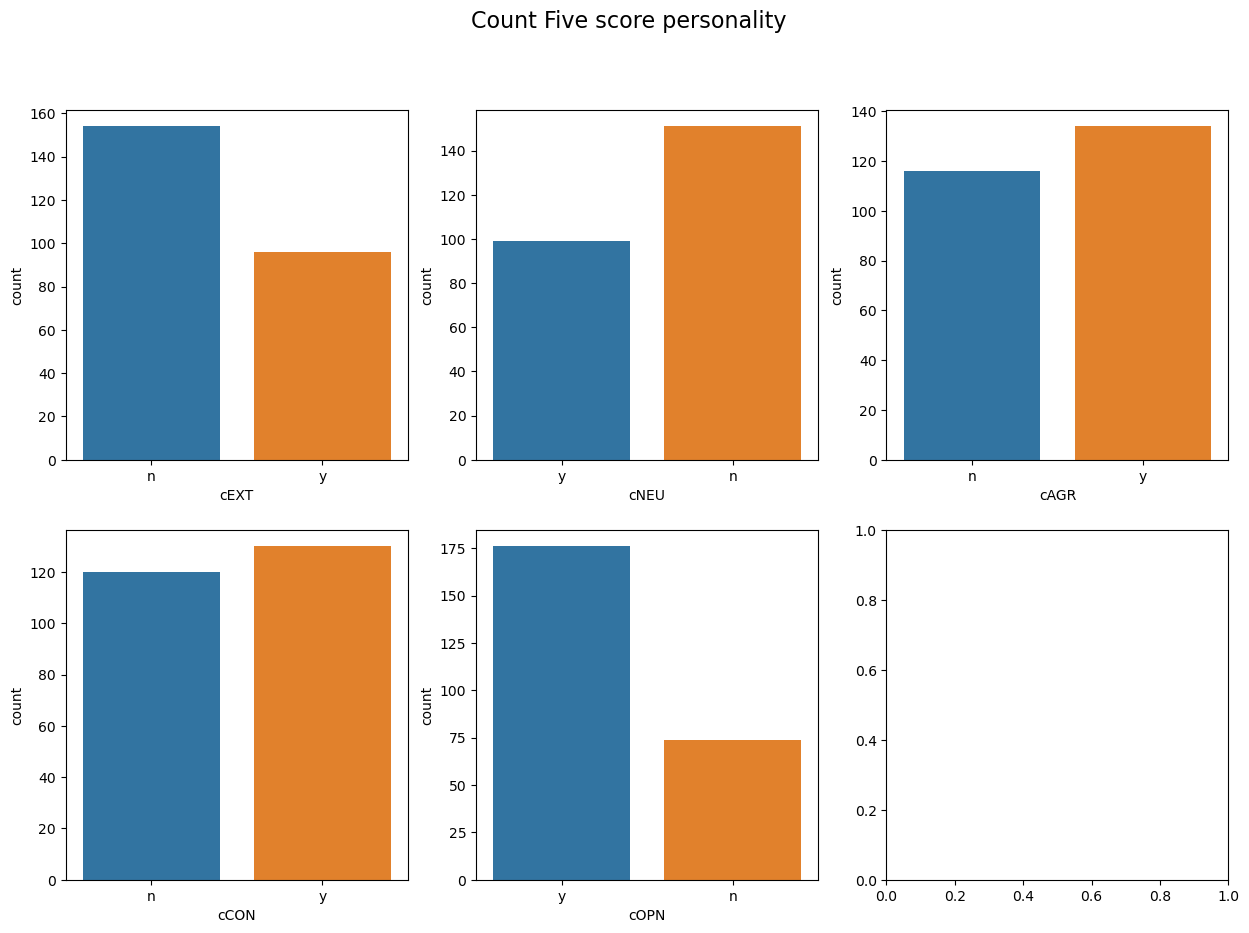

In [19]:
# plot users per category per trait
fig, axes = plt.subplots(2, 3, figsize=(15,10))

plt.suptitle('Count Five score personality', size=16)
for i, col in enumerate(['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']):
    x = i // 3
    y = i % 3
    sns.countplot(ax = axes[x, y], x = col, data = unique_users)

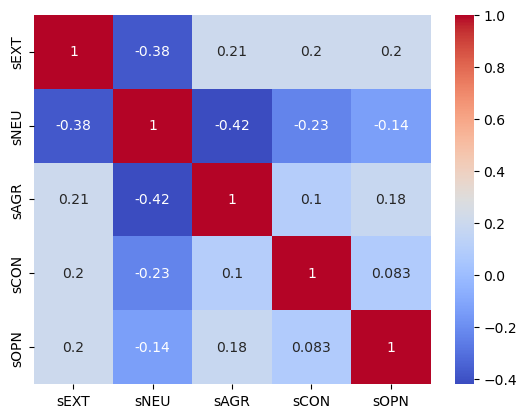

In [20]:
# heatmap correlation between traits
sns.heatmap(unique_users.corr(), annot=True, cmap='coolwarm');

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [21]:
df.groupby(['cOPN'])[['status_length', 'status_word_count']].agg(['mean'])

,status_length,status_word_count
,mean,mean
cOPN,,
n,85.686298,15.450726
y,78.905143,14.205184


In [22]:
df.groupby(['cCON'])[['status_length', 'status_word_count']].agg(['mean'])

,status_length,status_word_count
,mean,mean
cCON,,
n,81.920149,14.709515
y,79.149034,14.308165


In [23]:
df.groupby(['cEXT'])[['status_length', 'status_word_count']].agg(['mean'])

,status_length,status_word_count
,mean,mean
cEXT,,
n,79.866655,14.394428
y,81.704918,14.702305


In [24]:
df.groupby(['cAGR'])[['status_length', 'status_word_count']].agg(['mean'])

,status_length,status_word_count
,mean,mean
cAGR,,
n,80.976769,14.616692
y,80.355800,14.444276


In [25]:
df.groupby(['cNEU'])[['status_length', 'status_word_count']].agg(['mean'])

,status_length,status_word_count
,mean,mean
cNEU,,
n,80.852396,14.548314
y,80.304278,14.486414


**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

C:\Users\Win10\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Win10\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


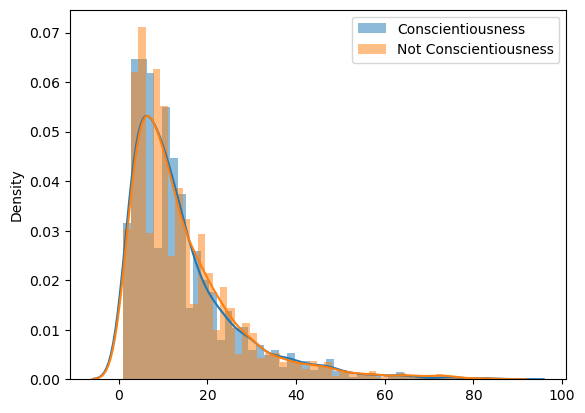

In [26]:
# plot cCON high and low distribution
sns.distplot(x=df[df['cCON']=='y']['status_word_count'], label='Conscientiousness', hist_kws={'alpha':0.5})
sns.distplot(x=df[df['cCON']=='n']['status_word_count'], label='Not Conscientiousness', hist_kws={'alpha':0.5})
plt.legend();

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [27]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words='english')

In [28]:
# fit and tranform status column
status_cvec = cvec.fit_transform(df['STATUS'])

In [29]:
# store to dataframe
status_cvec_df = pd.DataFrame(status_cvec.todense(), columns=cvec.get_feature_names_out())

### Show the 15 most common words

In [30]:
# count 15 most common words
most_com = status_cvec_df.sum().sort_values(ascending=False).head(15)
most_com

propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64

### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

<AxesSubplot:>

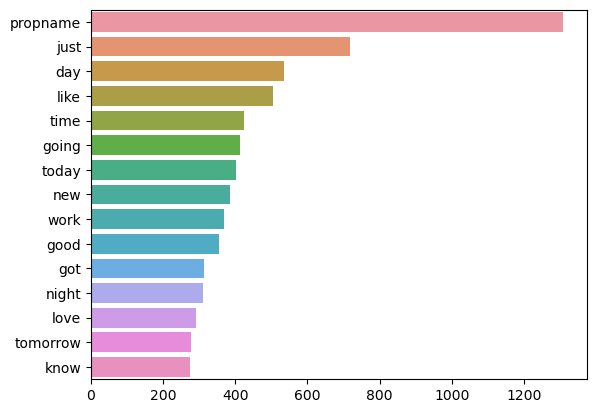

In [31]:
# plot most common words
sns.barplot(x=most_com, y=most_com.index)

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [32]:
# extract status columns that contain probname
df[df['STATUS'].str.contains('propname', case=False, regex=False)][['STATUS']].head(10)

,STATUS
6,"saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party."
18,"is tired. *PROPNAME*, let me go to sleep pl0x."
69,has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.
101,has a serious crush on *PROPNAME*. <3
104,Mondays are the new thursdays- anthony bourdain + *PROPNAME* = forgetting your financial troubles
118,is *PROPNAME*'s bestbian
139,is in love with *PROPNAME*.
158,is in love. With *PROPNAME*.
170,Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt
202,"ATTENTION EVERYONE!!! Vote for the short ""AFTER HOURS"" to support *PROPNAME* - our local Michigan talent and a wonderful person. Repost please!!! http:////www.thirteen.org//sites//reel13//category//vote//"


**Provide a short explanation of what you believe `propname` to be:**

Someone name but don't want to tell their name in public.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [33]:
# concat cAGR and Count-vectorized status 
text_and_scores = pd.concat([df['cAGR'], status_cvec_df], axis=1)

In [34]:
# display 5 rows of text_and_scores 
text_and_scores.head()

,cAGR,00,000,000ft,00am,00pm,01,02,02pm,03,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,n,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,n,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,n,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,n,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,n,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Show the 25 most common words for statuses from high-cAGR users:**

In [35]:
# show 25 most common words form high-cAGR
text_and_scores[text_and_scores['cAGR'] == 'y'].drop('cAGR', axis=1).sum().sort_values(ascending=False).head(25)

propname    699
just        402
day         297
like        280
time        221
today       219
work        206
good        201
going       200
new         194
love        172
happy       165
night       161
know        157
got         157
people      156
tomorrow    153
life        140
home        131
tonight     129
really      127
don         119
want        108
weekend     105
ll          103
dtype: int64

**Show the 25 most common words for statuses from low-cAGR users:**

In [36]:
# show 25 most common words form low-cAGR
text_and_scores[text_and_scores['cAGR'] == 'n'].drop('cAGR', axis=1).sum().sort_values(ascending=False).head(25)

propname    610
just        315
day         237
like        226
going       214
time        203
new         192
today       183
work        163
got         157
good        153
night       151
home        136
don         134
tonight     127
tomorrow    124
life        120
love        120
really      119
know        119
people      112
think       110
want        109
happy       107
week         98
dtype: int64

### (BONUS) Most common bigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [bigrams](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [37]:
# Instantiate CountVectorizer
bi_cvec = CountVectorizer(stop_words='english', ngram_range=(2,2))

# fit and tranform status column
status_bi_cvec = bi_cvec.fit_transform(df['STATUS'])

# store to dataframe
status_bi_cvec_df = pd.DataFrame(status_bi_cvec.todense(), columns=bi_cvec.get_feature_names_out())

# count 15 most common words
most_bi_com = status_bi_cvec_df.sum().sort_values(ascending=False).head(10)
most_bi_com

propname propname    147
just got              55
new year              53
http www              46
merry christmas       44
looking forward       43
feel like             39
happy new             32
don know              31
birthday wishes       29
dtype: int64

### (BONUS) Most common trigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [trigrams](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [38]:
# Instantiate CountVectorizer
tri_cvec = CountVectorizer(stop_words='english', ngram_range=(3,3))

# fit and tranform status column
status_tri_cvec = tri_cvec.fit_transform(df['STATUS'])

# store to dataframe
status_tri_cvec_df = pd.DataFrame(status_tri_cvec.todense(), columns=tri_cvec.get_feature_names_out())

# count 15 most common words
most_tri_com = status_tri_cvec_df.sum().sort_values(ascending=False).head(10)
most_tri_com

propname propname propname    54
gainesville film industry     23
www examiner com              23
http www examiner             23
24676 gainesville film        23
film industry examiner        23
happy new year                21
examiner com examiner         20
com examiner 24676            20
examiner 24676 gainesville    20
dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

In [39]:
# numbers been redacted, or are phone numbers, house numbers, or zip codes in the dataset
df[df['STATUS'].str.contains('address')][['STATUS']]

# There are house number been redacted in this dataset index 3171

,STATUS
3171,"When doing your Christmas cards, take one or more and send it to this address: A Recovering American Soldier c//o *PROPNAME* Army Medical Center 6900 Georgia Avenue NW; Washington, D.C. 20307. If we pass this on, think of how many cards these wonderful special people would get. PASS THIS ON TO ALL YOUR FRIENDS. (JUST COPY AND PASTE TO YOUR WALL)"
3849,"wonders which is more inappropriate; heckling during a Presidential address to Congress or the President himself calling a private citizen a ""jackass""."
6636,"anyone know if and where the state of the union address might be viewable online? I've googled it but can't find anything, and I don't have tv so I didn't get to watch it live :("
7505,"When sending your Christmas cards this year please take an extra one and send it to this address: A Recovering American Soldier c//o Walter Reed Army Medical Center 6900 Georgia Avenue NW; Washington, D.C. 20307. If we pass this on, think of how many cards our wonderful wounded military will get. PASS THIS ON TO ALL YOUR FRIENDS. (JUST COPY AND PASTE TO YOUR WALL)"
8439,"weird virus-type thingy just happened with facebook. closed facebook and a window popped up, ""about:blank"" in the address bar, with practically infinite tabs all with facebook...the computer was freezing up too badly to see what they all were."
9870,"My Indian address: 109 Blincoe Avon, Belmont Across from field next to warehouse, on curve Virginia, USA"


In [40]:
# numbers been redacted, or are phone numbers, house numbers, or zip codes in the dataset
df[df['STATUS'].str.contains('cell number')][['STATUS']]

# There are cell number been redacted in this dataset

,STATUS
2229,has a new cell number: (229) 251-4618. Save it now. SAVE IT!
2242,New cell number: (555) 555-5555


In [41]:
# Is count of uppercase letters vs. lowercase letters per status
# related to any personality category or personality score?
# create new column count uppercase and lowercase letter
df['uppercase'] = df['STATUS'].str.findall(r'[A-Z]').str.len()
df['lowercase'] = df['STATUS'].str.findall(r'[a-z]').str.len()

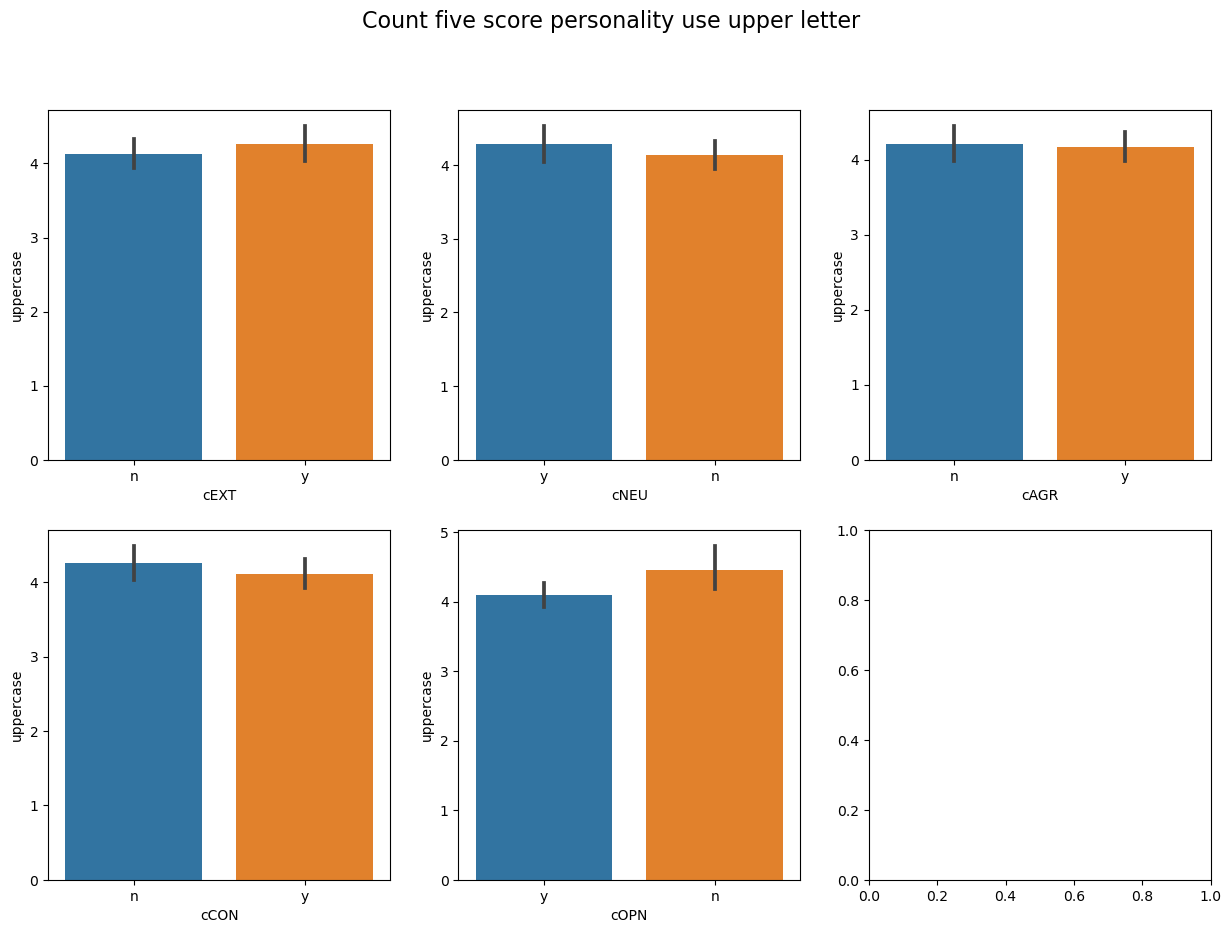

In [42]:
# plot users use uppercase per category per trait
fig, axes = plt.subplots(2, 3, figsize=(15,10))

plt.suptitle('Count five score personality use upper letter', size=16)
for i, col in enumerate(['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']):
    x = i // 3
    y = i % 3
    sns.barplot(ax = axes[x, y], x = col, y='uppercase', data = df)

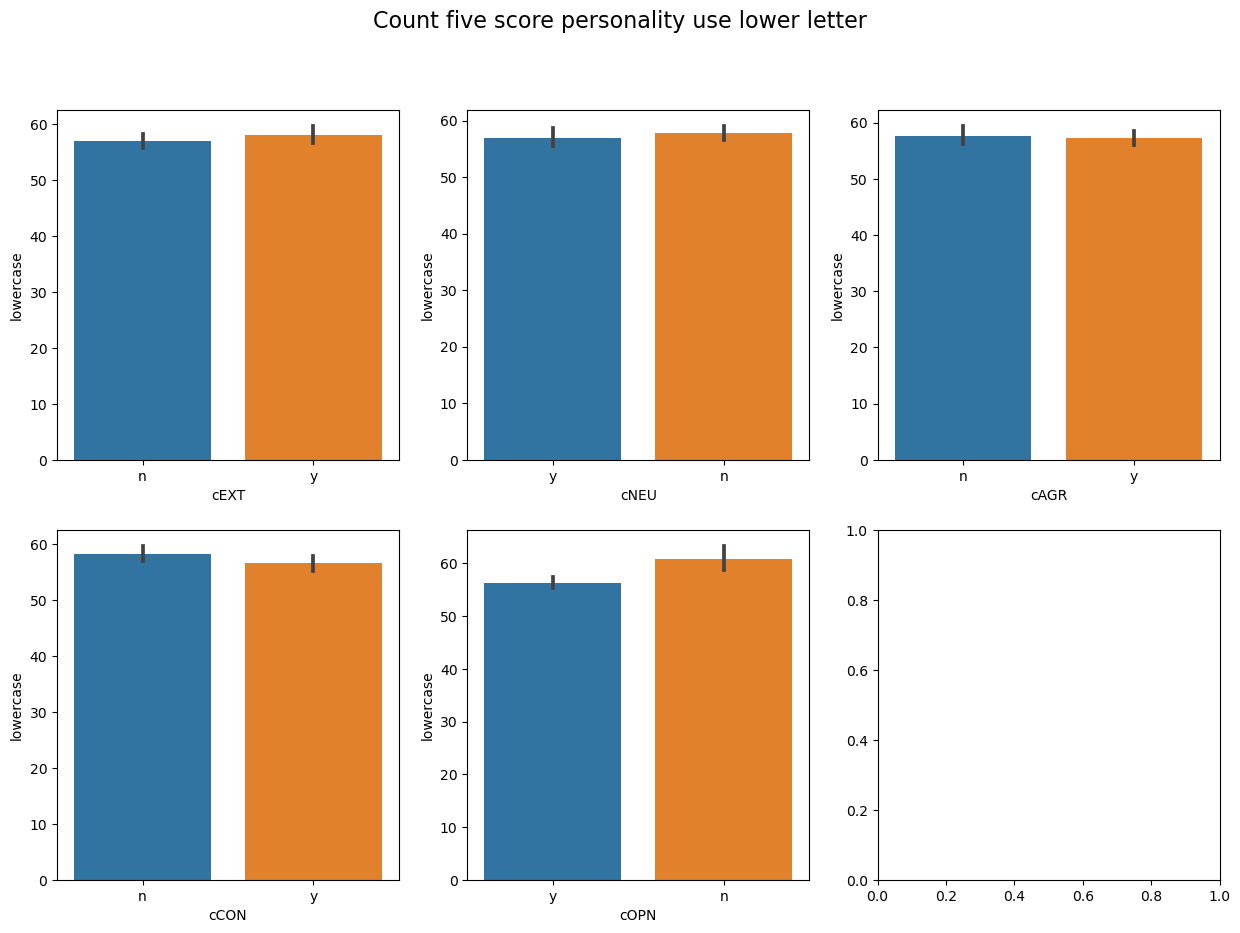

In [43]:
# plot users use lowercase per category per trait
fig, axes = plt.subplots(2, 3, figsize=(15,10))

plt.suptitle('Count five score personality use lower letter', size=16)
for i, col in enumerate(['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']):
    x = i // 3
    y = i % 3
    sns.barplot(ax = axes[x, y], x = col, y='lowercase', data = df)

In [44]:
# There are no different between traits by using uppercase or lowercase

---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

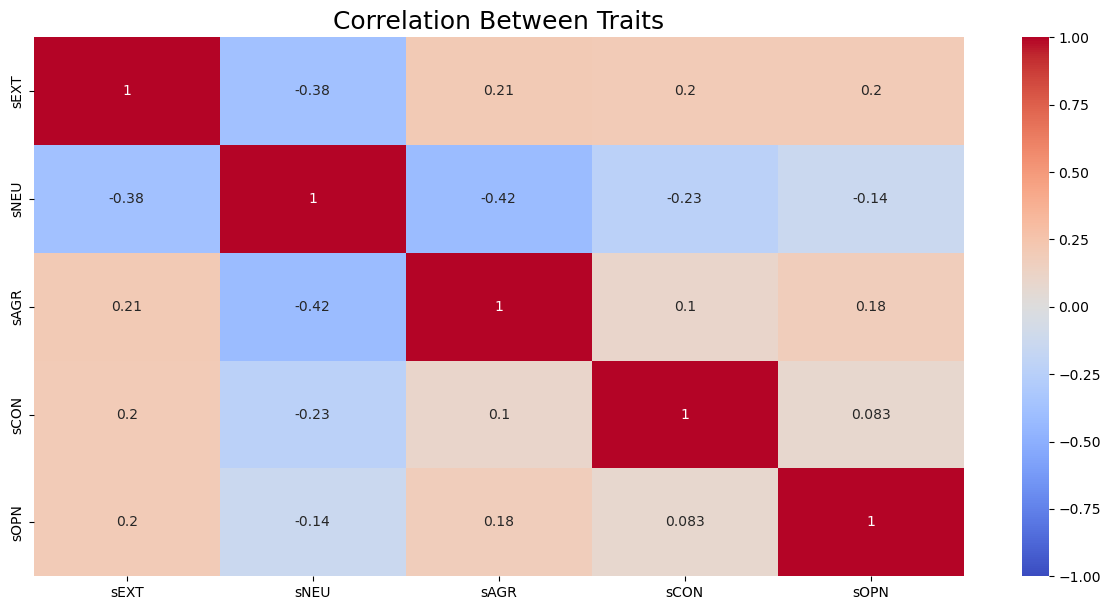

In [50]:
# heatmap correlation between traits
plt.figure(figsize=(15,7))
plt.title('Correlation Between Traits', size=18)
sns.heatmap(unique_users.corr(), annot=True, cmap='coolwarm',
           vmin=-1, vmax=1);

From this chart **Neuroticism** and **Agreeableness** there are have moderate inverse which could say if you're neurotic or easily to have anxiety you could likely be uncooperative.<br>
And **Neuroticism** and **Extraversion** there are also have moderate inverse if you're neurotic you could likely be shy person.